In [94]:
import gymnasium
import highway_env
from stable_baselines3 import DQN

Setting-up Ego environment

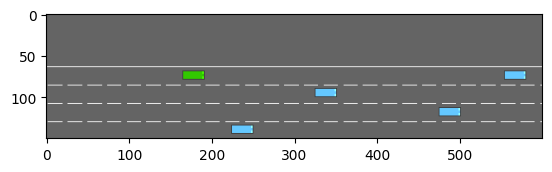

In [95]:
%matplotlib inline

env = gymnasium.make('highway-v0', render_mode='rgb_array')
env.reset()
for _ in range(3):
    action = env.unwrapped.action_type.actions_indexes["IDLE"]
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
plt.show()

Configuring Ego

In [96]:
print("entering training")
env = gymnasium.make("highway-fast-v0",render_mode='rgb_array', config={
      "simulation_frequency": 50,  # Lower number = slower simulation
    # "policy_frequency": 3

  })
model = DQN('MlpPolicy', env,
              policy_kwargs=dict(net_arch=[256, 256]),
              learning_rate=5e-4,
              buffer_size=15000,
              learning_starts=200,
              batch_size=32,
              gamma=0.8,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="highway_dqn/")


entering training
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
print("Training...")
model.learn(int(2e4))
print("training done")
model.save("highway_dqn/model")

Testing Ego

In [97]:
# Load and test saved model
model = DQN.load("highway_dqn/model_ego")
while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    

AttributeError: 'NoneType' object has no attribute 'get_image'

Configuring Multiagent environment

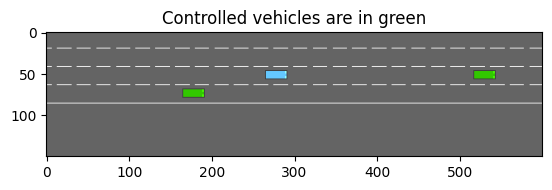

In [116]:
import time
import gymnasium
import highway_env

env = gymnasium.make(
  "highway-v0",
  render_mode="rgb_array",
  config={
    "controlled_vehicles": 2,  # Two controlled vehicles
    "vehicles_count": 1,       # A single other vehicle, for the sake of visualisation
  }
)
env.reset(seed=0)

from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(env.render())
plt.title("Controlled vehicles are in green")
plt.show()

time.sleep(3)
env.close()

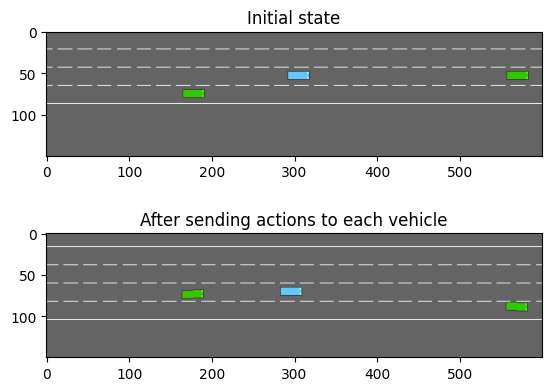

In [99]:
# Create environment with render_mode specified
# env = gymnasium.make('highway-v0', render_mode="rgb_array")

# Update the configuration
env.unwrapped.config.update({
    "action": {
        "type": "MultiAgentAction",
        "action_config": {
            "type": "DiscreteMetaAction",
        }
    }
})

# Reset the environment
env.reset()

# Create the plot
_, (ax1, ax2) = plt.subplots(nrows=2)

# Get and display the initial state
rgb_array = env.render()
ax1.imshow(rgb_array)
ax1.set_title("Initial state")

# Make the first vehicle change to the left lane, and the second one to the right
action_1, action_2 = 0, 2  # See highway_env.envs.common.action.DiscreteMetaAction.ACTIONS_ALL
env.step((action_1, action_2))

# Get and display the state after action
rgb_array = env.render()
ax2.imshow(rgb_array)
ax2.set_title("After sending actions to each vehicle")
plt.show()

time.sleep(3)
env.close()


# # Load and test saved model
# model = DQN.load("highway_dqn/model_ego")
# while True:
#   done = truncated = False
#   obs, info = env.reset()
#   while not (done or truncated):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, reward, done, truncated, info = env.step(action)
#     env.render()
    

In [114]:
env = gymnasium.make(
  "highway-v0",
  render_mode="rgb_array",
  config={
    "observation": {
      "type": "MultiAgentObservation",
      "observation_config": {
        "type": "Kinematics",
      }
    }
  }
)
obs, info = env.reset()

import pprint
pprint.pprint(obs)

(array([[ 1.        ,  0.87817526,  0.5       ,  0.3125    ,  0.        ],
       [ 1.        ,  0.09803256, -0.5       , -0.03920713,  0.        ],
       [ 1.        ,  0.19852456, -0.25      , -0.02304366,  0.        ],
       [ 1.        ,  0.3151201 ,  0.25      , -0.02236085,  0.        ],
       [ 1.        ,  0.41809636, -0.25      , -0.03965277,  0.        ]],
      dtype=float32),)


In [119]:
# Multi-agent environment configuration
# Make sure multiple vehicles are spawned
env.unwrapped.configure({
    "controlled_vehicles": 2,  # Explicitly set to 2 vehicles
    "vehicles_count": 2,      # Total number of vehicles on highway
    "show_trajectories": True,  # Optional: helps visualize vehicle paths
    "initial_lane_id": 0,    # Starting lane for first vehicle
    "other_vehicles_type": "highway_en.vehicle.behavior.IDMVehicle"
})

env.unwrapped.config.update({
  "controlled_vehicles": 2,
  "observation": {
    "type": "MultiAgentObservation",
    "observation_config": {
      "type": "Kinematics",
    }
  },
  "action": {
    "type": "MultiAgentAction",
    "action_config": {
      "type": "DiscreteMetaAction",
    }
  }
})

model_bh_drive = DQN.load("highway_dqn/model_bh_drive0")
model_ego = DQN.load("highway_dqn/model_ego")

models = [model_bh_drive, model_ego]

obs, info = env.reset()
done = truncated = False
while not (done or truncated):
  action = tuple(model.predict(obs_i, deterministic=True)[0] for model, obs_i in zip(models, obs))
  next_obs, reward, done, truncated, info = env.step(action)
  env.render()
  obs = next_obs

#   def predict(self, obs):
#     return 0

#   def update(self, obs, action, next_obs, reward, info, done, truncated):
#     pass
# model = Model()

# # A training episode
# obs, info = env.reset()
# done = truncated = False
# while not (done or truncated):
#   # Dispatch the observations to the model to get the tuple of actions
#   action = tuple(model.predict(obs_i) for obs_i in obs)
#   # Execute the actions
#   next_obs, reward, done, truncated, info = env.step(action)
#   # Update the model with the transitions observed by each agent
#   for obs_i, action_i, next_obs_i in zip(obs, action, next_obs):
#     model.update(obs_i, action_i, next_obs_i, reward, info, done, truncated)
#   obs = next_obs


# env.render()
# time.sleep(3)
# env.close()

ModuleNotFoundError: No module named 'highway_en'

In [40]:
env.render()
time.sleep(3)
env.close()

In [127]:
import gymnasium
import numpy as np
from stable_baselines3 import DQN
import time

# 1. Create environment with render mode
env = gymnasium.make('highway-v0', render_mode="rgb_array")

# 2. Basic environment configuration
env.unwrapped.configure({
    "controlled_vehicles": 2,      # Number of vehicles controlled
    "vehicles_count": 2,           # Total vehicles in the env
    "show_trajectories": True,     # Visualize trajectories
    "initial_lane_id": 1,         # Starting lane
    "screen_width": 600,          # For better visualization
    "screen_height": 400,
    "simulation_frequency": 20,    # FPS
    "policy_frequency": 5,
    # Set initial positions for the two vehicles
    "initial_positions": [
        [0, 0],    # First vehicle: [longitudinal, lateral]
        [20, 1]    # Second vehicle: different lane and distance
    ]
})

# 3. Multi-agent configuration
env.unwrapped.config.update({
    "controlled_vehicles": 2,
    "observation": {
        "type": "MultiAgentObservation",
        "observation_config": {
            "type": "Kinematics",
        }
    },
    "action": {
        "type": "MultiAgentAction",
        "action_config": {
            "type": "DiscreteMetaAction",
        }
    }
})

# 4. Load your trained models
model_ego = DQN.load("highway_dqn/model_ego")
model_bh_drive0 = DQN.load("highway_dqn/model_bh_drive0")

# Create list of models in order of vehicle control
models = [model_ego, model_bh_drive0]

# 5. Run the simulation
obs, info = env.reset()

# Verify we have two vehicles
print(f"Number of vehicles being observed: {len(obs)}")
print(f"Observation shapes: {[o.shape for o in obs]}")

done = truncated = False
while not (done or truncated):
    # Get actions from each model
    action = tuple(model.predict(obs_i, deterministic=True)[0] 
                  for model, obs_i in zip(models, obs))
    
    # Execute actions
    next_obs, reward, done, truncated, info = env.step(action)
    
    # Render
    env.render()
    
    # Optional: add delay to better visualize
    time.sleep(0.1)  # Adjust this value to change visualization speed
    
    obs = next_obs

# Wait 3 seconds before closing
time.sleep(3)
env.close()

Number of vehicles being observed: 2
Observation shapes: [(5, 5), (5, 5)]
